# VISION : TME – impl´ementation de deux m´ethodes de flot optique
Bînome :
- Etudiant 1 : Samy Rayan RAMOUL.
- Etudiant 2 : Saad EL MADAFRI

Sujet : https://www-pequan.lip6.fr/~bereziat/cours/master/vision/vision-of.pdf

In [1]:
!wget --no-check-certificate "https://pequan.lip6.fr/~bereziat/cours/master/vision/tme.tgz"
!tar xvzf tme.tgz

--2021-02-09 19:05:05--  https://pequan.lip6.fr/~bereziat/cours/master/vision/tme.tgz
Resolving pequan.lip6.fr (pequan.lip6.fr)... 132.227.74.4
Connecting to pequan.lip6.fr (pequan.lip6.fr)|132.227.74.4|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 2865162 (2.7M) [application/x-gzip]
Saving to: ‘tme.tgz.1’

tme.tgz.1           100%[===================>]   2.73M   526KB/s    in 5.3s    

2021-02-09 19:05:11 (526 KB/s) - ‘tme.tgz.1’ saved [2865162/2865162]

data/mysine/mysine10.png
data/mysine/mysine9.png
data/nasa/nasa10.png
data/nasa/nasa9.png
data/rubberwhale/frame10.png
data/rubberwhale/frame11.png
data/rubic/rubic10.png
data/rubic/rubic9.png
data/square/square10.png
data/square/square9.png
data/taxi/taxi10.png
data/taxi/taxi9.png
data/yosemite/yos10.png
data/yosemite/yos9.png
data/mysine/correct_mysine.flo
data/rubberwhale/correct_rubberwhale10.flo
data/square/correct_square.flo
data/yosemite/correct_yos.

In [2]:
%run "python/middlebury.py"
import tqdm.notebook as tq
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from scipy.ndimage.filters import convolve

#  Méthode de Horn et Schunck

In [3]:
def gradhorn(I1, I2):
    kernelX = np.array([[-1, 1],[-1, 1]]) * 1/4
    kernelY = np.array([[-1,-1],[ 1, 1]]) * 1/4
    kernelT = np.ones((2,2))*1/4

    Ix = convolve(I1, kernelX) + convolve(I2,  kernelX)
    Iy = convolve(I1, kernelY) + convolve(I2,  kernelY)
    It = convolve(I1,  kernelT) + convolve(I2, -kernelT)
    return Ix, Iy, It 


In [30]:
def horn(I1,I2,alpha,N):
    I1 = cv2.imread(I1, 0).astype(np.float32)
    I2 = cv2.imread(I2, 0).astype(np.float32)
    Ix, Iy, It = gradhorn(I1, I2)
    A = np.matrix([[1/12, 1/6, 1/12],  [1/6, 0, 1/6], [1/12, 1/6, 1/12]])

    u_0 = np.zeros([I1.shape[0],I1.shape[1]])
    v_0 = np.zeros([I1.shape[0],I1.shape[1]])

    u_k = u_0
    v_k = v_0
    for k in range(0, N-1):
        u_bar_k = convolve(u_k, A)
        v_bar_k = convolve(v_k, A)
        
        supp = ( ( Ix*u_bar_k ) + ( Iy*v_bar_k ) + It )
        inf = alpha + Ix**2 + Iy**2
        derivatives = np.divide(supp, inf)

        u_k = u_bar_k - Ix * derivatives
        v_k = v_bar_k - Iy * derivatives
    
    w = np.zeros([ I1.shape[0], I1.shape[1], 2 ])
    w[: , : , 0] = u_k
    w[: , : , 1] = v_k
    return w
def err_angulaire(REF, HS):
    supp = 1 + REF*HS
    inf = np.sqrt(  1 + np.linalg.norm(REF)**2  ) + np.sqrt( 1 + np.linalg.norm(HS)**2 )
    return np.mean(np.arccos( np.divide(supp, inf) ), axis=(0,1,2))


def optimize_horn_schunck(I1, I2, REF, min_alpha=1, max_alpha=100, N=100):
    best_error = 9999
    best_alpha = 9999
    best_N = 0
    X = []
    Y = []
    for alpha in tq.tqdm(range(min_alpha, max_alpha)):
        HS = horn(I1, I2, alpha, N)
        err = err_angulaire(REF, HS)
        
        X.append(alpha)
        Y.append(err)
        if err<best_error:
            best_error = err
            best_alpha = alpha
            best_N = N
    #plt.plot(X, Y)
    #plt.show()
    ax = sns.relplot(x=X, y=Y, kind="line")
    ax.set(xlabel='Alpha', ylabel='Erreur Angulaire')
    plt.title("Résultat de l'optimisation avec N="+str(N))
    plt.show()
    print("Meilleure erreur angulaire = "+str(best_error))
    return best_alpha, best_N


## Mysine
Au vu de l'évolution du graphe on pourrait obtenir de meilleurs résultats en testant des valeurs plus élevées d'alpha.

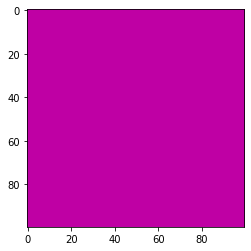

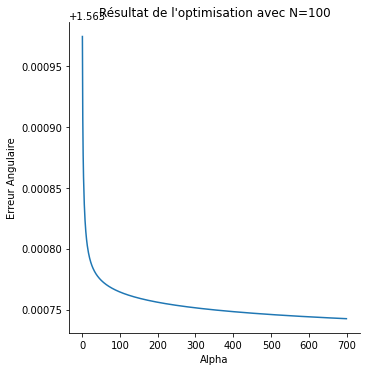

Meilleure erreur angulaire = 1.5637424910300508
Best alpha  = 699
Best N = 100


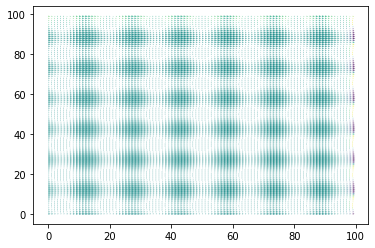

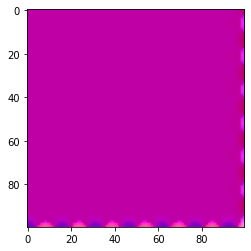

In [28]:

REF = readflo('data/mysine/correct_mysine.flo')
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()


I1, I2 = 'data/mysine/mysine9.png', 'data/mysine/mysine10.png'
alpha, N = optimize_horn_schunck(I1, I2, REF, max_alpha=700)

print("Best alpha  = "+str(alpha))
print("Best N = "+str(N))
HS = horn('data/mysine/mysine9.png', 'data/mysine/mysine10.png', alpha, N)

plt.quiver(cv2.flip(cv2.imread(I1, 0), 0).astype(np.float32),HS[:, :, 0], HS[:, :, 1] )
plt.show()
plt.imshow(computeColor(HS[:, :, 0], HS[:, :, 1], False))
plt.show()

## Nasa

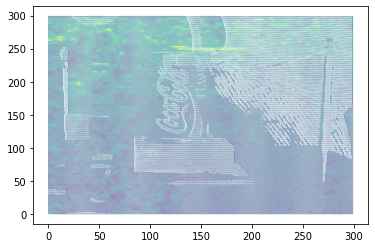

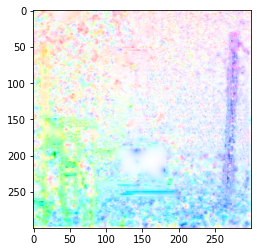

In [27]:
alpha = 15
N = 100
HS = horn('data/nasa/nasa9.png', 'data/nasa/nasa10.png', alpha, N)
plt.quiver(cv2.flip(cv2.imread('data/nasa/nasa9.png', 0), 0).astype(np.float32),HS[:, :, 0], HS[:, :, 1] )
plt.show()
plt.imshow(computeColor(HS[:, :, 0], HS[:, :, 1], False))
plt.show()

***Rubberwhale*** \\
Sur cette image on peut observer sur le graphe qu'il y'a une valeur d'alpha minimisant l'erreur angulaire.

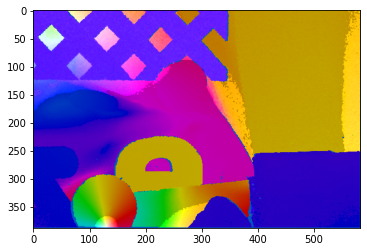

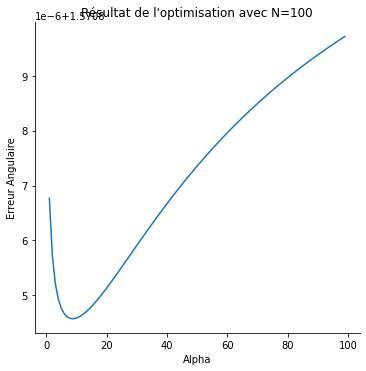

Meilleure erreur angulaire = 1.5708045739704466
Best alpha  = 9
Best N = 100


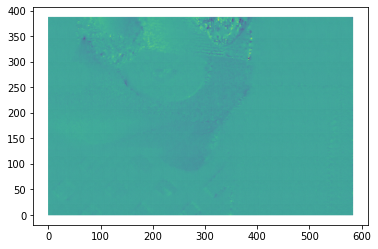

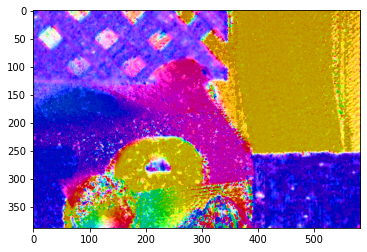

In [26]:

REF = readflo('data/rubberwhale/correct_rubberwhale10.flo')
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()


I1, I2 = 'data/rubberwhale/frame10.png', 'data/rubberwhale/frame11.png'
alpha, N = optimize_horn_schunck(I1, I2, REF)

print("Best alpha  = "+str(alpha))
print("Best N = "+str(N))
HS = horn('data/rubberwhale/frame10.png', 'data/rubberwhale/frame11.png', alpha, N)

plt.quiver(cv2.flip(cv2.imread(I1, 0), 0).astype(np.float32),HS[:, :, 0], HS[:, :, 1] )
plt.show()


plt.imshow(computeColor(HS[:, :, 0], HS[:, :, 1], False))
plt.show()

## Rubic

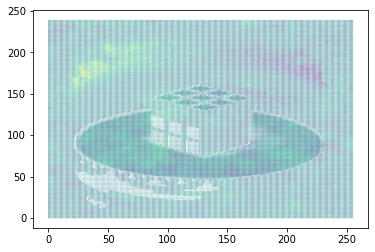

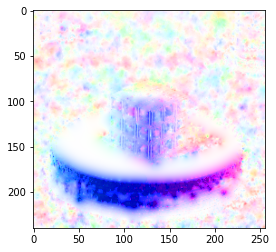

In [25]:
alpha = 10
N = 100
HS = horn('data/rubic/rubic9.png', 'data/rubic/rubic10.png', alpha, N)
plt.quiver(cv2.flip(cv2.imread('data/rubic/rubic9.png', 0),0).astype(np.float32),HS[:, :, 0], HS[:, :, 1] )
plt.show()
plt.imshow(computeColor(HS[:, :, 0], HS[:, :, 1], False))
plt.show()

## Square

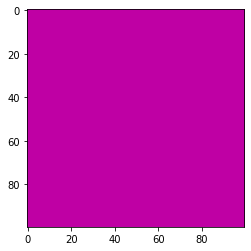

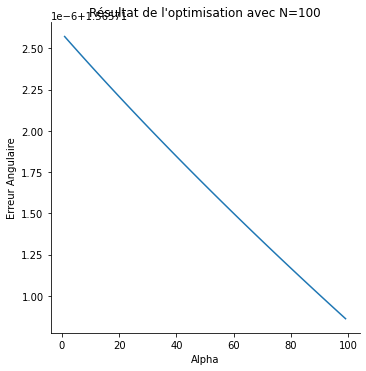

Meilleure erreur angulaire = 1.5657108619193407


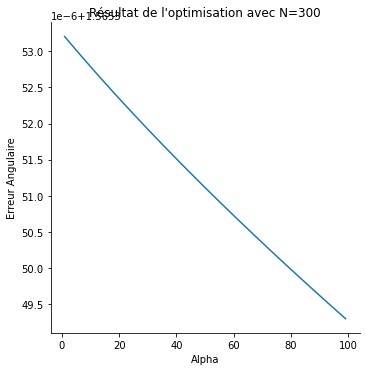

Meilleure erreur angulaire = 1.5653492985706694


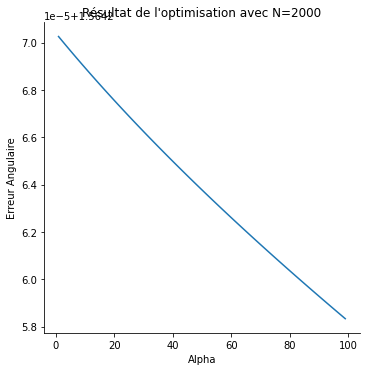

Meilleure erreur angulaire = 1.5642583331041222
Best alpha  = 99
Best N = 2000


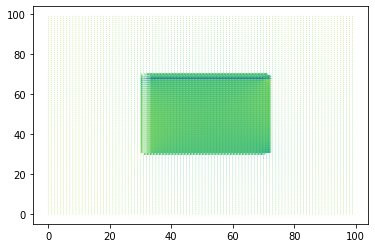

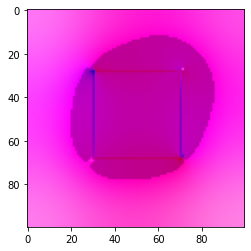

In [15]:
REF = readflo('data/square/correct_square.flo')
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()


I1, I2 = 'data/square/square9.png', 'data/square/square10.png'
alpha, N = optimize_horn_schunck(I1, I2, REF)

I1, I2 = 'data/square/square9.png', 'data/square/square10.png'
alpha, N = optimize_horn_schunck(I1, I2, REF, N=300)


I1, I2 = 'data/square/square9.png', 'data/square/square10.png'
alpha, N = optimize_horn_schunck(I1, I2, REF, N=2000)

print("Best alpha  = "+str(alpha))
print("Best N = "+str(N))
HS = horn('data/square/square9.png', 'data/square/square10.png', alpha, N)
plt.quiver(cv2.flip(cv2.imread(I1, 0).astype(np.float32), 0),HS[:, :, 0], HS[:, :, 1] )
plt.show()

plt.imshow(computeColor(HS[:, :, 0], HS[:, :, 1], False))
plt.show()

## Taxi

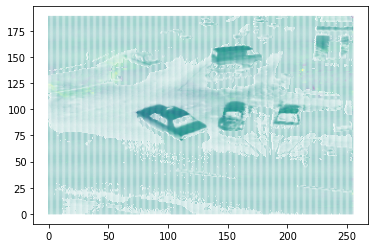

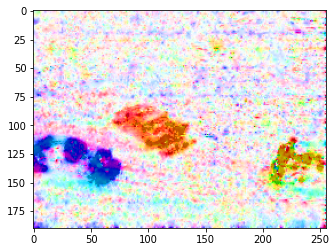

In [14]:
alpha = 10
N = 100
HS = horn('data/taxi/taxi9.png', 'data/taxi/taxi10.png', alpha, N)

plt.quiver(cv2.flip(cv2.imread('data/taxi/taxi9.png', 0), 0).astype(np.float32),HS[:, :, 0], HS[:, :, 1] )
plt.show()


plt.imshow(computeColor(HS[:, :, 0], HS[:, :, 1], False))
plt.show()

Yosemite \\
Pour cette image des valeurs d'alpha beaucoup plus elevées doivent être testées au vu du premier graphe de l'evolution de l'erreur angulaire, et en testant 2 plages différentes de valeurs sur la première on observe la décroissance de l'erreur et sur la deuxième la croissance on peut déduire que l'alpha optimal devrait se situer entre ces deux plages de valeurs.

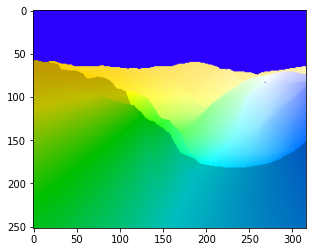

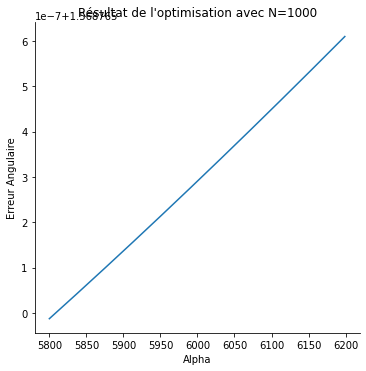

Meilleure erreur angulaire = 1.5687649875295124
Best alpha  = 5800
Best N = 1000


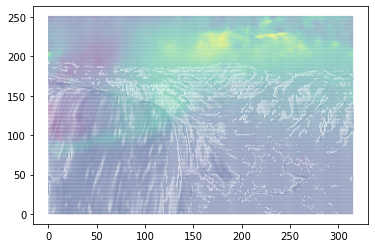

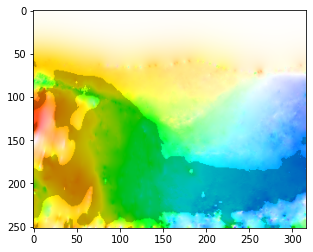

In [32]:

REF = readflo('data/yosemite/correct_yos.flo')
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()


I1, I2 = 'data/yosemite/yos9.png', 'data/yosemite/yos10.png'
alpha, N = optimize_horn_schunck(I1, I2, REF, min_alpha=5800, max_alpha=6200, N=1000)

print("Best alpha  = "+str(alpha))
print("Best N = "+str(N))
HS = horn('data/yosemite/yos9.png', 'data/yosemite/yos10.png', alpha, N)

plt.quiver(cv2.flip(cv2.imread(I1, 0), 0).astype(np.float32),HS[:, :, 0], HS[:, :, 1] )
plt.show()



plt.imshow(computeColor(HS[:, :, 0], HS[:, :, 1], False))
plt.show()

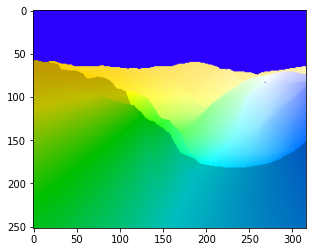

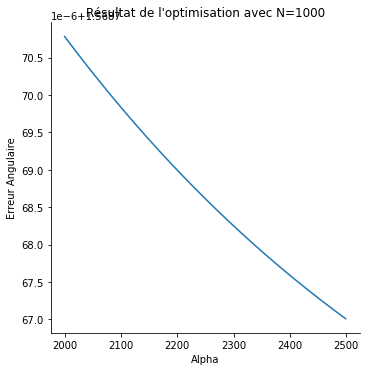

Meilleure erreur angulaire = 1.568767009217411
Best alpha  = 2499
Best N = 1000


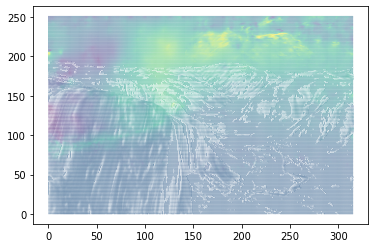

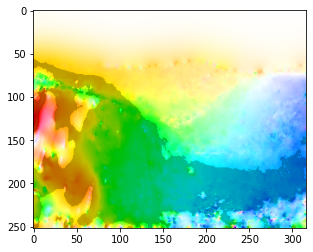

In [33]:
REF = readflo('data/yosemite/correct_yos.flo')
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()


I1, I2 = 'data/yosemite/yos9.png', 'data/yosemite/yos10.png'
alpha, N = optimize_horn_schunck(I1, I2, REF, min_alpha=2000, max_alpha=2500, N=1000)

print("Best alpha  = "+str(alpha))
print("Best N = "+str(N))
HS = horn('data/yosemite/yos9.png', 'data/yosemite/yos10.png', alpha, N)

plt.quiver(cv2.flip(cv2.imread(I1, 0), 0).astype(np.float32),HS[:, :, 0], HS[:, :, 1] )
plt.show()



plt.imshow(computeColor(HS[:, :, 0], HS[:, :, 1], False))
plt.show()

Globalement les résultats obtenus et représentés grâce à la fonction computeColor sont assez représentatifs des mouvements des objets, même s'ils restent cependant trés bruités comparativement aux vérités terrain existantes.

## **Méthode de Lucas et Kanade**

In [17]:
def lucas(I1,I2,n):
    I1 = cv2.imread(I1, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    I2 = cv2.imread(I2, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    Ix, Iy, It = gradhorn(I1, I2)
    w = int(n/2)
    u = np.zeros(I1.shape)
    v = np.zeros(I1.shape)
    for i in range(w,I1.shape[0]-w):
      for j in range(w,I1.shape[1]-w):
        fx = Ix[i-w:i+w+1,j-w:j+w+1].flatten()
        fy = Iy[i-w:i+w+1,j-w:j+w+1].flatten()
        ft = -It[i-w:i+w+1,j-w:j+w+1].flatten()
        b = np.reshape(ft, (ft.shape[0],1))
        A = np.vstack((fx, fy)).T
        nu = np.matmul(np.linalg.pinv(A), b)
        u[i,j] = nu[0]
        v[i,j] = nu[1]
      
    return (u,v)

***Mysine***

L'erreur commise est de l'ordre de :  1.5672382574783097


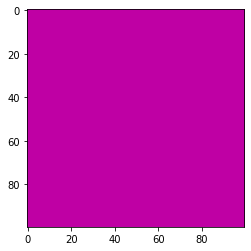

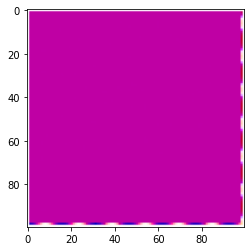

In [18]:
u,v = lucas('data/mysine/mysine9.png', 'data/mysine/mysine10.png',3)
REF = readflo('data/mysine/correct_mysine.flo')
print("L'erreur commise est de l'ordre de : ",err_angulaire(REF,np.array((u,v)).reshape((u.shape[0],u.shape[1],2))))
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()

plt.imshow(computeColor(u, v))
plt.show()


***Rubberwhale***

L'erreur commise est de l'ordre de :  1.5707916644370308


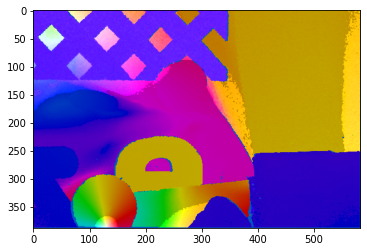

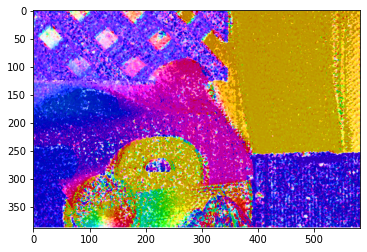

In [19]:
u,v = lucas('data/rubberwhale/frame10.png', 'data/rubberwhale/frame11.png',3)
REF = readflo('data/rubberwhale/correct_rubberwhale10.flo')
print("L'erreur commise est de l'ordre de : ",err_angulaire(REF,np.array((u,v)).reshape((u.shape[0],u.shape[1],2))))
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()

plt.imshow(computeColor(u, v))
plt.show()


***Rubic***

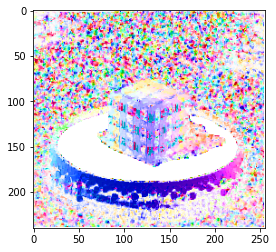

In [20]:
u,v = lucas('data/rubic/rubic9.png', 'data/rubic/rubic10.png',3)
plt.imshow(computeColor(u, v))
plt.show()


**Square**

L'erreur commise est de l'ordre de :  1.566419782908054


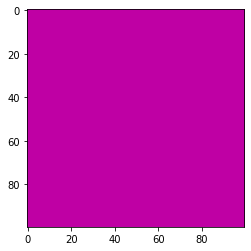

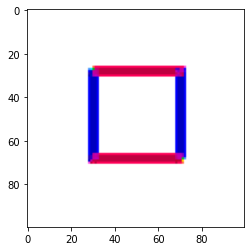

In [21]:
u,v = lucas('data/square/square9.png', 'data/square/square10.png',3)
REF = readflo('data/square/correct_square.flo')
print("L'erreur commise est de l'ordre de : ",err_angulaire(REF,np.array((u,v)).reshape((u.shape[0],u.shape[1],2))))
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()

plt.imshow(computeColor(u, v))
plt.show()

**Nasa**

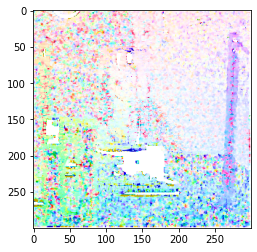

In [22]:
u,v = lucas('data/nasa/nasa9.png', 'data/nasa/nasa10.png',3)
plt.imshow(computeColor(u, v))
plt.show()


**Taxi**

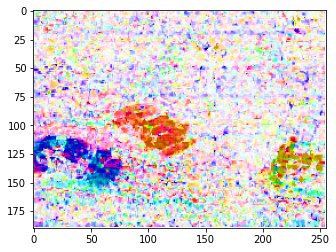

In [23]:
u,v = lucas('data/taxi/taxi9.png', 'data/taxi/taxi10.png',3)
plt.imshow(computeColor(u, v))
plt.show()

**Yosemite**

L'erreur commise est de l'ordre de :  1.5696796717618955


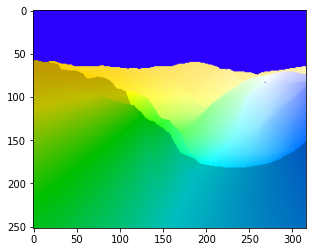

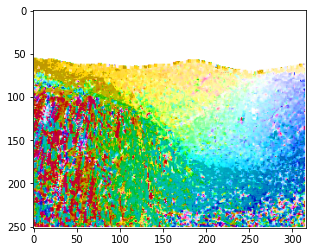

In [24]:
u,v = lucas('data/yosemite/yos9.png', 'data/yosemite/yos10.png',3)
REF = readflo('data/yosemite/correct_yos.flo')
print("L'erreur commise est de l'ordre de : ",err_angulaire(REF,np.array((u,v)).reshape((u.shape[0],u.shape[1],2))))
plt.imshow(computeColor(REF[:, :, 0], REF[:, :, 1], False))
plt.show()

plt.imshow(computeColor(u, v))
plt.show()

Les résultats de cette deuxième méthode sont très similaires à la première.